In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from ncps.wirings import NCP, AutoNCP
from ncps.torch import LTC
from sklearn.model_selection import train_test_split

from state_representation import ImageDataset, NormalizeTransform, record_resets
from utils import train
from state_representation.models import CoordRegressorCNN
from utils.config import AE_CONFIG
from utils.visualization import VisualBackpropWrapper

/home/felix/anaconda3/envs/ADLR2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data collection and preprocessing

In [2]:
IMAGE_PATH = "./state_representation/reset_image_data_agent"
LABEL_PATH = "./state_representation/reset_label_data_agent"
BATCH_SIZE = 32

#### Record images of the environment including agent, target and static / dynamic obstacles

In [3]:
# record_resets(IMAGE_PATH, 10000, AE_CONFIG.env)

#### Load data from disk into memory

In [4]:
transform = NormalizeTransform(start=(0, 255), end=(0, 1))
dataset = ImageDataset(IMAGE_PATH, LABEL_PATH, transform=transform)

#### Create and save labels on disk

NOTE: This will override existing ones!

In [5]:
# labels = []

# blue = torch.tensor([0., 0., 1.])
# for image in dataset:
#     agent = []
#     for i, h in enumerate(image):
#         for j, w in enumerate(h):
#             if w.equal(blue):
#                 agent.append((i, j))
    
#     center = np.round(np.array(agent).mean(axis=0)).astype(int)
#     labels.append(center)

# labels = torch.tensor(np.array(labels))
# torch.save(labels, LABEL_PATH + ".pt")

In [6]:
print(f"Image shape: {dataset.images.shape}")
print(f"Label shape: {dataset.labels.shape}")

n_samples = len(dataset)
train_idx, val_idx = train_test_split(range(n_samples), test_size=0.1)

train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=BATCH_SIZE,
    num_workers=4
)

n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

Image shape: torch.Size([10000, 3, 128, 128])
Label shape: torch.Size([10000, 2])


# Training a Liquid Neural Network

In [7]:
torch.set_float32_matmul_precision('medium')
in_features = np.square(14) * 32
out_features = 2
sparsity = 0.6

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron
# wiring = NCP(
#     inter_neurons=16,
#     command_neurons=8,
#     motor_neurons=out_features,
#     sensory_fanout=int(16 * sparsity),
#     inter_fanout=int(8 * sparsity),
#     recurrent_command_synapses=int(8 * sparsity),
#     motor_fanin=int(8 * sparsity)
# )
bn = nn.BatchNorm2d
activation = nn.ReLU

features_extractor = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=5, stride=1),
    bn(8), activation(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1),
    bn(16), activation(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1),
    bn(32), activation(),
    nn.AvgPool2d(2, 2),
)

regression_head = nn.Sequential(
    nn.Flatten(),
    LTC(in_features, wiring, batch_first=True)
)

model = CoordRegressorCNN(features_extractor, regression_head, lr=0.01)
model

CoordRegressorCNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LTC(
      (rnn_cell): LTCCell(
        (make_positive_fn): Softplus(beta=1, threshold=20)
        (_clip): ReLU()
      )
    )
  )
)

#### Train the model for 20 epochs

In [8]:
train(model, 20, train_loader, val_loader)

Validation Epoch [20/20]: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 61.43it/s, val_loss=1.68421]


#### Save & Load

In [ ]:
# NOTE: save trained model (overwrites existing one!)
# torch.save(model, "./state_representation/lnn_model.pt")
# NOTE: load trained model for evaluation
# model = torch.load("./state_representation/lnn_model.pt")

#### Visualize performance

Yellow cross => true center of the agent to be tracked  
Red cross => predicted center

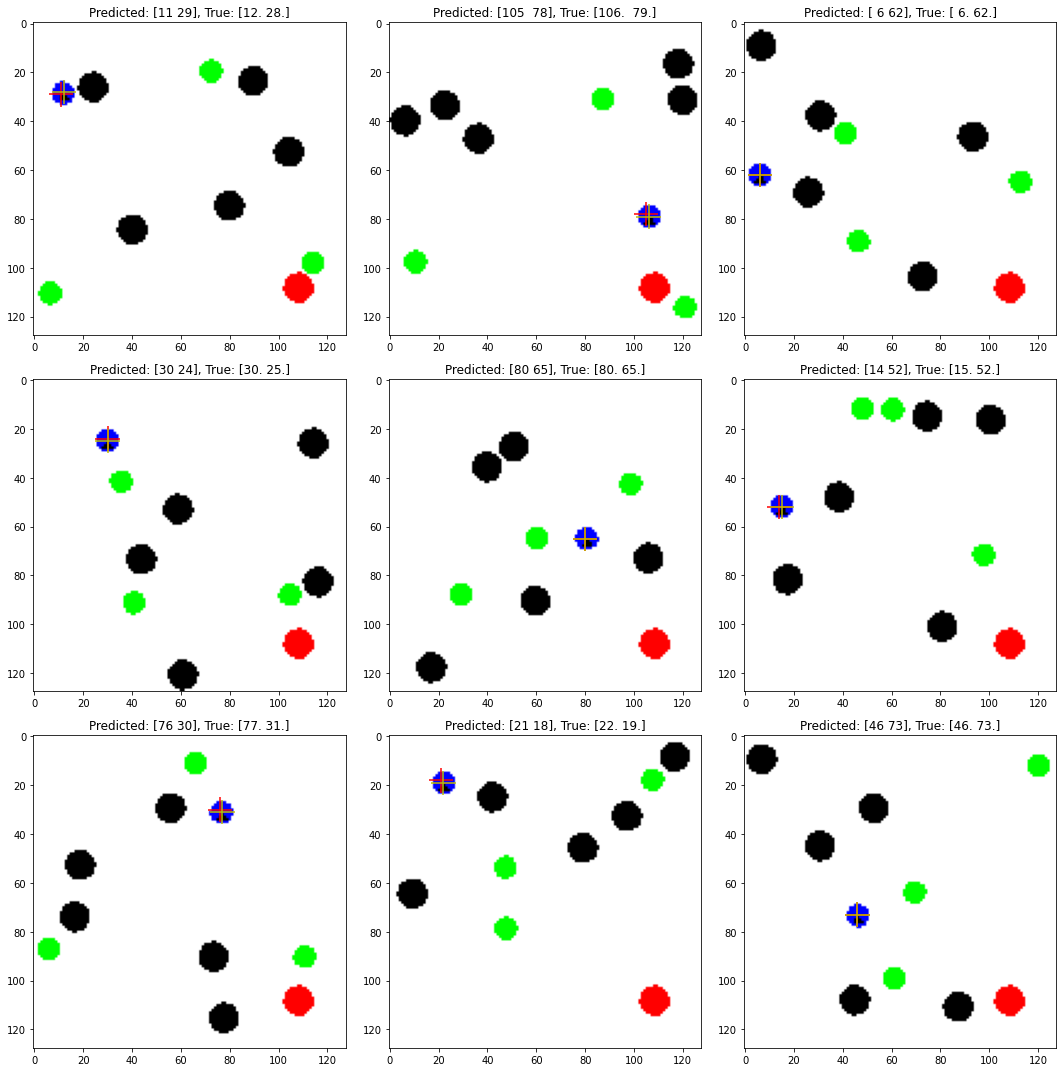

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for pos, i in enumerate(np.random.randint(0, n_val, size=9, dtype=int)):
    sample = val_loader.dataset[i][0].unsqueeze(0)
    label = val_loader.dataset[i][1]

    with torch.no_grad():
        prediction = model.forward(sample.to(model.device))
        prediction = prediction[0].cpu().detach().numpy().astype(int)[0]

    ax[pos % 3][pos // 3].axes.imshow(sample[0].numpy().transpose(1, 2, 0))
    ax[pos % 3][pos // 3].set_title(f"Predicted: {prediction}, True: {label.numpy()}")
    # cross-hair on predicted position
    x, y = prediction
    ax[pos % 3][pos // 3].axes.vlines(x, y-5, y+5, color="r")
    ax[pos % 3][pos // 3].axes.hlines(y, x-5, x+5, color="r")
    # cross-hair on true positon
    x, y = label
    ax[pos % 3][pos // 3].axes.vlines(x, y-5, y+5, color="y")
    ax[pos % 3][pos // 3].axes.hlines(y, x-5, x+5, color="y")
plt.tight_layout()
plt.show()

#### Visualize attention using VisualBackProp

Inpaint models attention to input features in order to make decisions more explainable.

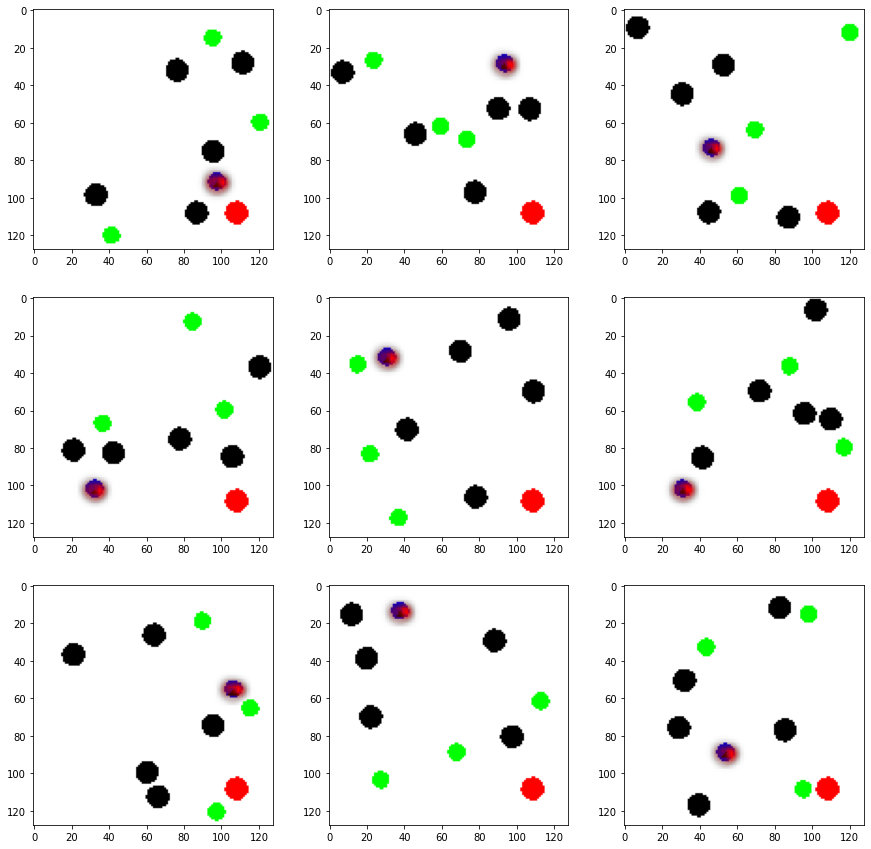

In [12]:
def visualize_images_with_masks(images, masks, ax):
    images = images.cpu()
    red_mask = np.zeros((images.shape[0], images.shape[2], images.shape[3], 4))
    masks_np = masks.detach().cpu().numpy()
    red_mask[:,:,:,0] = np.squeeze(masks_np, 1)
    red_mask[:,:,:,3] = red_mask[:,:,:,0]

    for i in range(images.shape[0]):
        img = images[i].transpose(0, 1)
        img = img.transpose(1, 2)
        ax.imshow(img)#, cmap='gray')
        ax.imshow(red_mask[i] / np.max(red_mask[i]))

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for pos, i in enumerate(np.random.randint(0, n_val, size=9, dtype=int)):
    sample = val_loader.dataset[i][0].unsqueeze(0).to(model.device)
    visual = VisualBackpropWrapper(model, device="cuda")
    masks = visual.get_masks_for_batch(sample)
    visualize_images_with_masks(sample, masks, ax[pos % 3][pos // 3])